In [1]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425345 sha256=63527f25c19ebf66ba99a98ff12a01ae06a80bb7bfa62b2b289977e188db1137
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


In [2]:
from pyspark import SparkContext
from pyspark.sql.functions import col
from pyspark.sql import SparkSession
from pyspark.sql.functions import mean, min, max, stddev
import matplotlib.pyplot as plt

spark = SparkSession\
        .builder\
        .master('local[*]')\
        .getOrCreate()
sc = spark.sparkContext

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
%cd /content/drive/My Drive/Colab Notebooks/CSCI657/
!ls

/content/drive/My Drive/Colab Notebooks/CSCI657
 anime.csv  'Project 1 Source Code.ipynb'   rating.csv


In [5]:
from pyspark.sql import SQLContext

sqlContext = SQLContext(sc)

df = sqlContext.read.load('/content/drive/My Drive/Colab Notebooks/CSCI657/anime.csv',
                     format = 'com.databricks.spark.csv',
                     header = 'true',
                     inferSchema = 'true')

filtered_df = df.filter((df['episodes'] != "Unknown") & (df['episodes'] > 0))

/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:113: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [6]:
filtered_df.show()

+--------+--------------------+--------------------+-----+--------+------+-------+
|anime_id|                name|               genre| type|episodes|rating|members|
+--------+--------------------+--------------------+-----+--------+------+-------+
|   32281|      Kimi no Na wa.|Drama, Romance, S...|Movie|       1|  9.37| 200630|
|    5114|Fullmetal Alchemi...|Action, Adventure...|   TV|      64|  9.26| 793665|
|   28977|            Gintama°|Action, Comedy, H...|   TV|      51|  9.25| 114262|
|    9253|         Steins;Gate|    Sci-Fi, Thriller|   TV|      24|  9.17| 673572|
|    9969|       Gintama&#039;|Action, Comedy, H...|   TV|      51|  9.16| 151266|
|   32935|Haikyuu!!: Karasu...|Comedy, Drama, Sc...|   TV|      10|  9.15|  93351|
|   11061|Hunter x Hunter (...|Action, Adventure...|   TV|     148|  9.13| 425855|
|     820|Ginga Eiyuu Densetsu|Drama, Military, ...|  OVA|     110|  9.11|  80679|
|   15335|Gintama Movie: Ka...|Action, Comedy, H...|Movie|       1|   9.1|  72534|
|   

In [7]:
# Compute mean, min, max, and standard deviation
mean_result = filtered_df.agg(mean('episodes').alias('mean_episodes'),
                    mean('rating').alias('mean_rating'),
                    mean('members').alias('mean_members'))

min_result = filtered_df.agg(min('episodes').alias('min_episodes'),
                   min('rating').alias('min_rating'),
                   min('members').alias('min_members'))

max_result = filtered_df.agg(max('episodes').alias('max_episodes'),
                   max('rating').alias('max_rating'),
                   max('members').alias('max_members'))

std_result = filtered_df.agg(stddev('episodes').alias('stddev_episodes'),
                      stddev('rating').alias('stddev_rating'),
                      stddev('members').alias('stddev_members'))

mean_result.show()
min_result.show()
max_result.show()
std_result.show()

+------------------+-----------------+-----------------+
|     mean_episodes|      mean_rating|     mean_members|
+------------------+-----------------+-----------------+
|12.382549774134182|6.480333445604587|18368.56140204116|
+------------------+-----------------+-----------------+

+------------+----------+-----------+
|min_episodes|min_rating|min_members|
+------------+----------+-----------+
|           1|      1.67|          5|
+------------+----------+-----------+

+------------+----------+-----------+
|max_episodes|max_rating|max_members|
+------------+----------+-----------+
|          99|      10.0|    1013917|
+------------+----------+-----------+

+-----------------+------------------+-----------------+
|  stddev_episodes|     stddev_rating|   stddev_members|
+-----------------+------------------+-----------------+
|46.86535196440979|1.0219945856095332|55110.77583825718|
+-----------------+------------------+-----------------+



In [8]:
# Convert df to ARFF format
arff_content = "@relation anime_dataset\n\n"
arff_content += "@attribute anime_id numeric\n"
arff_content += "@attribute name string\n"
arff_content += "@attribute genre string\n"
arff_content += "@attribute type string\n"
arff_content += "@attribute episodes numeric\n"
arff_content += "@attribute rating numeric\n"
arff_content += "@attribute members numeric\n\n"
arff_content += "@data\n"

# Iterate over rows in filered _df (removed rows with "Unknown" value)
for row in filtered_df.collect():
    row_values = [str(row.anime_id), row.name or '?',
    row.genre or '?', row.type or '?', str(row.episodes)
    if row.episodes is not None else '?', str(row.rating)
    if row.rating is not None else '?', str(row.members)
    if row.members is not None else '?']
    arff_content += ",".join(row_values) + "\n"

# Write ARFF content to file
# and save to directory
with open('anime.arff', 'w') as f:
    f.write(arff_content)

print("Converted Successfully")

Converted Successfully


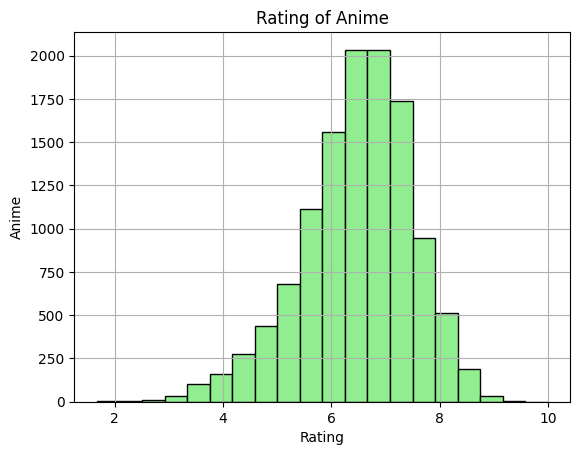

In [9]:
rating_anime = filtered_df.select('rating').rdd.flatMap(lambda x: x).collect()
rating_anime = [rating for rating in rating_anime if rating is not None]

plt.hist(rating_anime, bins=20, color='lightgreen', edgecolor='black')
plt.xlabel('Rating')
plt.ylabel('Anime')
plt.title('Rating of Anime')
plt.grid(True)
plt.show()

#about 4200 anime is rated between 6.5 to 7.

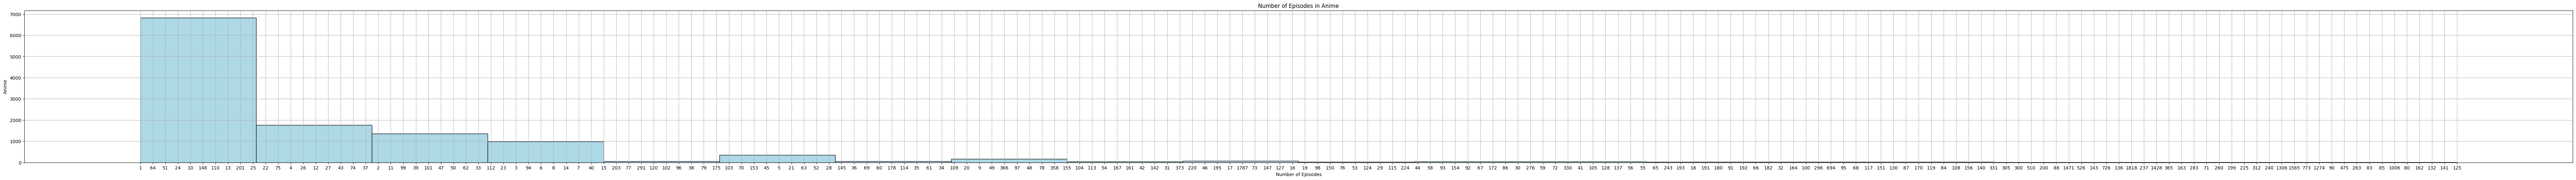

In [10]:
episodes_distribution = filtered_df.select('episodes').rdd.flatMap(lambda x: x).collect()
episodes_distribution = [episodes for episodes in episodes_distribution if episodes is not None]

plt.figure(figsize=(100, 6))
plt.hist(episodes_distribution, bins=20, color='lightblue', edgecolor='black')
plt.xlabel('Number of Episodes')
plt.ylabel('Anime')
plt.title('Number of Episodes in Anime')
plt.grid(True)
plt.show()
#About 6800 anime has only one episode.